In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Server:
    def __init__(self, capacity=1.0, speed=1.0):
        self.capacity = capacity
        self.speed = speed
        self.current_load = 0.0
        self.tasks = []

    def add_task(self, load, duration):
        self.tasks.append([float(load), float(duration)])
        self.current_load += load

    def update(self):
        finished = []

        for task in self.tasks:
            load, duration = task
            utilization = self.current_load / self.capacity

            if utilization <= 0.5:
                progress = self.speed
            elif utilization <= 0.8:
                penalty = (utilization - 0.5) / 0.3
                progress = self.speed * (1 - penalty * 0.3)
            else:
                penalty = (utilization - 0.8) / 0.2
                progress = self.speed * (1 - 0.3 - penalty * 0.5)

            task[1] -= progress

            if task[1] <= 0:
                finished.append(task)

        for f in finished:
            self.tasks.remove(f)
            self.current_load -= f[0]


In [ ]:
def generate_gradient_datasets(seed_base=300, num_datasets=5, num_tasks=800):

    # Parametri za "slabi" dataset
    weak_params = {
        "traffic_min": 0.3,
        "traffic_max": 0.7,
        "burst_prob_factor": 0.1,
        "burst_range": (2,6),
        "heavy_task_prob": 0.15,
        "heavy_load_range": (3.0,5.0),
        "heavy_duration_range": (40,70),
        "light_load_range": (1.0,2.0),
        "light_duration_range": (8,20),
        "interval_range": (3,7)
    }

    # Parametri za "jaki" dataset
    strong_params = {
        "traffic_min": 0.5,
        "traffic_max": 1.0,
        "burst_prob_factor": 0.2,
        "burst_range": (3,7),
        "heavy_task_prob": 0.2,
        "heavy_load_range": (3.5,6.0),
        "heavy_duration_range": (50,90),
        "light_load_range": (1.5,3.0),
        "light_duration_range": (12,30),
        "interval_range": (2,5)
    }

    datasets = []

    for idx in range(num_datasets):
        random.seed(seed_base + idx)
        tasks = []
        current_time = 0

        # Interpolacija parametara
        frac = idx / (num_datasets - 1)  
        traffic_min = weak_params["traffic_min"] + frac * (strong_params["traffic_min"] - weak_params["traffic_min"])
        traffic_max = weak_params["traffic_max"] + frac * (strong_params["traffic_max"] - weak_params["traffic_max"])
        burst_prob_factor = weak_params["burst_prob_factor"] + frac * (strong_params["burst_prob_factor"] - weak_params["burst_prob_factor"])
        burst_range = (int(weak_params["burst_range"][0] + frac*(strong_params["burst_range"][0]-weak_params["burst_range"][0])),
                       int(weak_params["burst_range"][1] + frac*(strong_params["burst_range"][1]-weak_params["burst_range"][1])))
        heavy_task_prob = weak_params["heavy_task_prob"] + frac*(strong_params["heavy_task_prob"] - weak_params["heavy_task_prob"])
        heavy_load_range = (weak_params["heavy_load_range"][0] + frac*(strong_params["heavy_load_range"][0]-weak_params["heavy_load_range"][0]),
                            weak_params["heavy_load_range"][1] + frac*(strong_params["heavy_load_range"][1]-weak_params["heavy_load_range"][1]))
        heavy_duration_range = (weak_params["heavy_duration_range"][0] + frac*(strong_params["heavy_duration_range"][0]-weak_params["heavy_duration_range"][0]),
                                weak_params["heavy_duration_range"][1] + frac*(strong_params["heavy_duration_range"][1]-weak_params["heavy_duration_range"][1]))
        light_load_range = (weak_params["light_load_range"][0] + frac*(strong_params["light_load_range"][0]-weak_params["light_load_range"][0]),
                            weak_params["light_load_range"][1] + frac*(strong_params["light_load_range"][1]-weak_params["light_load_range"][1]))
        light_duration_range = (weak_params["light_duration_range"][0] + frac*(strong_params["light_duration_range"][0]-weak_params["light_duration_range"][0]),
                                weak_params["light_duration_range"][1] + frac*(strong_params["light_duration_range"][1]-weak_params["light_duration_range"][1]))
        interval_range = (weak_params["interval_range"][0] + frac*(strong_params["interval_range"][0]-weak_params["interval_range"][0]),
                          weak_params["interval_range"][1] + frac*(strong_params["interval_range"][1]-weak_params["interval_range"][1]))

        # Generisanje zadataka
        for _ in range(num_tasks):
            time_of_day = (current_time % 1440) / 1440
            traffic_intensity = traffic_min + (traffic_max - traffic_min) * math.sin(time_of_day * math.pi)
            burst_prob = burst_prob_factor * traffic_intensity
            num_burst = random.randint(*burst_range) if random.random() < burst_prob else 1

            for _ in range(num_burst):
                arrival = current_time
                if random.random() < heavy_task_prob:
                    load = random.uniform(*heavy_load_range)
                    duration = random.randint(int(heavy_duration_range[0]), int(heavy_duration_range[1]))
                else:
                    load = random.uniform(*light_load_range) * traffic_intensity
                    duration = random.randint(int(light_duration_range[0]), int(light_duration_range[1]))
                tasks.append((arrival, load, duration))

            interval = max(1, int(random.randint(int(interval_range[0]), int(interval_range[1])) / traffic_intensity))
            current_time += interval

        max_time = current_time + 300
        datasets.append((tasks, max_time))

    return datasets


DATASET_DIR = "/content/drive/MyDrive/load_balancer_datasets"
os.makedirs(DATASET_DIR, exist_ok=True)


gradient_datasets = generate_gradient_datasets(seed_base=100, num_datasets=5, num_tasks=800)

datasets = []
for i, (tasks, max_time) in enumerate(gradient_datasets):
    path = f"{DATASET_DIR}/dataset_{i}.pkl"
    with open(path, "wb") as f:
        pickle.dump((tasks, max_time), f)
    datasets.append(path)

print("Saved 5 datasets to:", DATASET_DIR)

Saved 5 datasets to: /content/drive/MyDrive/load_balancer_datasets


In [ ]:
SERVER_CONFIG_DIR = "/content/drive/MyDrive/load_balancer_server_configs"
os.makedirs(SERVER_CONFIG_DIR, exist_ok=True)

server_configs_list = [
    # homogeni
    [(5,1.0)] * 7,

    # blago heterogeni
    [(5,0.8),(6,1.0),(5,0.9),(7,1.2),(5,0.85),(6,1.1),(5,0.95)],

    # jaki heterogeni
    [(5,0.7),(10,1.4),(3,0.5),(12,1.6),(4,0.6),(8,1.3),(5,0.9)],

    # ekstremni
    [(2,0.4),(15,1.8),(2,0.4),(15,1.8),(2,0.4),(15,1.8),(2,0.4)],

    # realistični miks
    [(5,1.0),(7,1.3),(6,1.1),(5,0.9),(6,1.0),(7,1.2),(5,0.95)]
]

server_config_paths = []
for i, config in enumerate(server_configs_list):
    path = f"{SERVER_CONFIG_DIR}/server_config_{i}.pkl"
    with open(path,"wb") as f:
        pickle.dump(config,f)
    server_config_paths.append(path)

print("Saved 5 server configs to:", SERVER_CONFIG_DIR)


Saved 6 server configs to: /content/drive/MyDrive/load_balancer_server_configs


In [ ]:
class RoundRobinBalancer:
    def __init__(self, servers):
        self.servers = servers
        self.index = 0

    def assign(self, task):
        _, load, duration = task
        overhead = 0
        for _ in range(len(self.servers)):
            overhead += 0.1
            s = self.servers[self.index]
            self.index = (self.index + 1) % len(self.servers)
            if s.current_load + load <= s.capacity:
                s.add_task(load,duration)
                return True, overhead
        return False, overhead

def power_of_n_balancer(servers, task, n):
    overhead = n*0.1
    _, load, duration = task
    sampled = random.sample(servers,n)
    sampled.sort(key=lambda s: s.current_load / (s.capacity * s.speed))
    for s in sampled:
        if s.current_load + load <= s.capacity:
            s.add_task(load,duration)
            return True, overhead
    return False, overhead


In [ ]:
def simulate(servers, tasks, max_time, assign_fn, balancer_capacity_per_tick=10):
    t = 0
    task_index = 0
    queue = []
    usage_history = []
    queue_snapshots = []
    tasks_assigned = 0
    total_overhead = 0

    while t <= max_time:
        for s in servers:
            s.update()

        decisions_remaining = balancer_capacity_per_tick

        new_arrivals = []
        while task_index < len(tasks) and tasks[task_index][0]==t:
            new_arrivals.append(tasks[task_index])
            task_index +=1

        for task in new_arrivals:
            if decisions_remaining <= 0:
                queue.append(task)
            else:
                assigned, overhead = assign_fn(task)
                total_overhead += overhead
                decisions_remaining -= 1
                if assigned:
                    tasks_assigned += 1
                else:
                    queue.append(task)

        tasks_to_retry = min(decisions_remaining,len(queue))
        new_queue=[]
        for i, task in enumerate(queue):
            if i<tasks_to_retry:
                assigned, overhead = assign_fn(task)
                total_overhead += overhead
                if assigned:
                    tasks_assigned +=1
                else:
                    new_queue.append(task)
            else:
                new_queue.append(task)
        queue=new_queue

        usage_history.append([s.current_load for s in servers])
        queue_snapshots.append(len(queue))
        t+=1

    return usage_history, queue_snapshots, tasks_assigned, total_overhead


In [ ]:
pn_results_per_config=[]
rr_results_per_config=[]

for config_path in server_config_paths:
    with open(config_path,"rb") as f:
        server_configs = pickle.load(f)

    pn_metrics=[]
    rr_metrics=[]

    for dataset_path in datasets:
        with open(dataset_path,"rb") as f:
            tasks,max_time = pickle.load(f)
        total_tasks = len(tasks)

        # Power-of-n
        servers_pn = [Server(c,s) for c,s in server_configs]
        def pn_assign(task):
            return power_of_n_balancer(servers_pn, task, n=2)
        usage_pn, queue_pn, assigned_pn, overhead_pn = simulate(servers_pn, tasks, max_time, pn_assign)
        pn_metrics.append((usage_pn, queue_pn, assigned_pn, overhead_pn))

        # Round Robin
        servers_rr = [Server(c,s) for c,s in server_configs]
        rr_balancer = RoundRobinBalancer(servers_rr)
        def rr_assign(task):
            return rr_balancer.assign(task)
        usage_rr, queue_rr, assigned_rr, overhead_rr = simulate(servers_rr, tasks, max_time, rr_assign)
        rr_metrics.append((usage_rr, queue_rr, assigned_rr, overhead_rr))

    pn_results_per_config.append(pn_metrics)
    rr_results_per_config.append(rr_metrics)




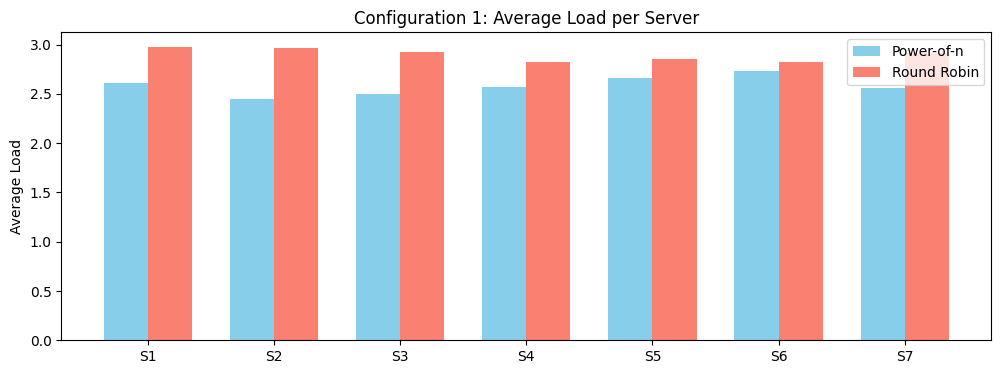

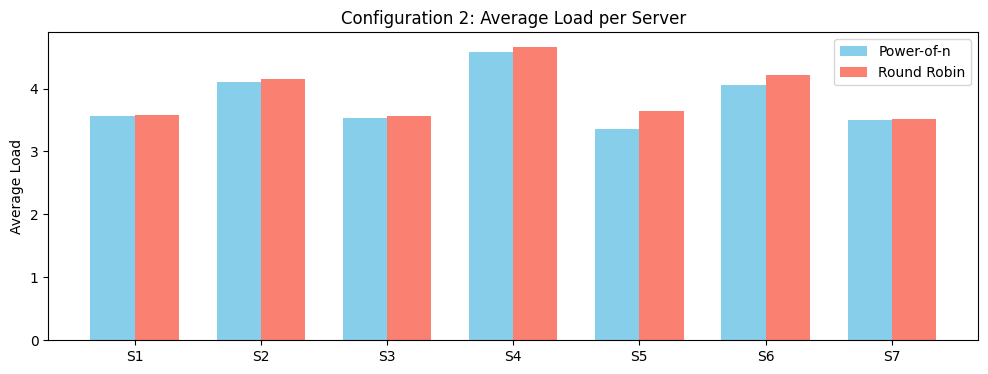

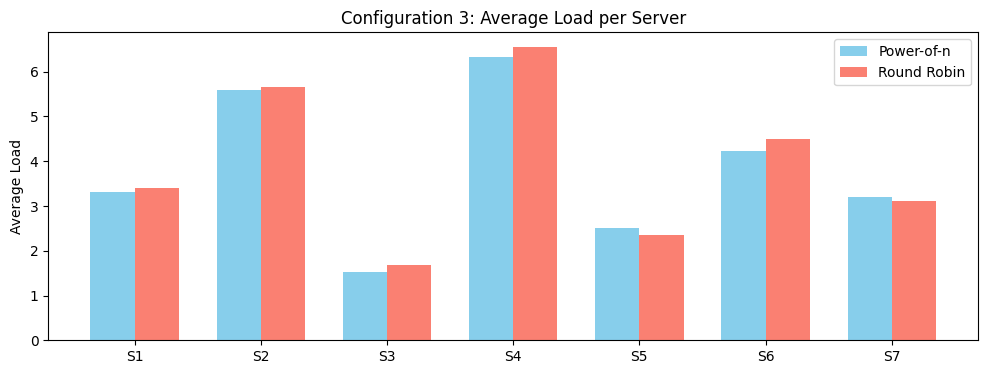

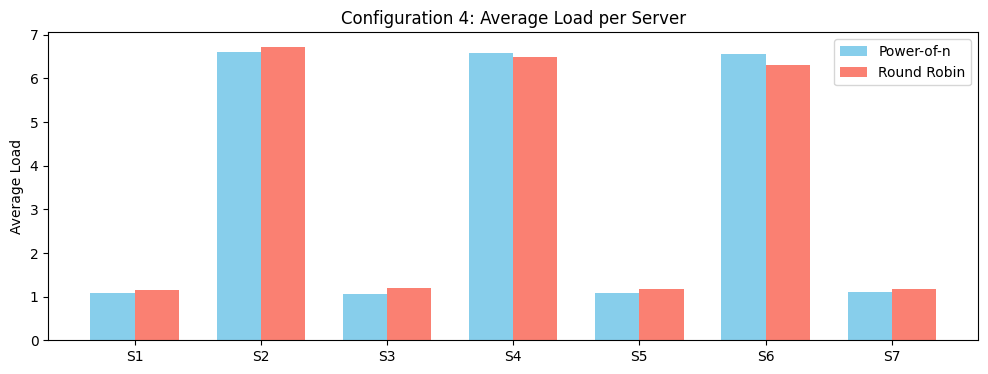

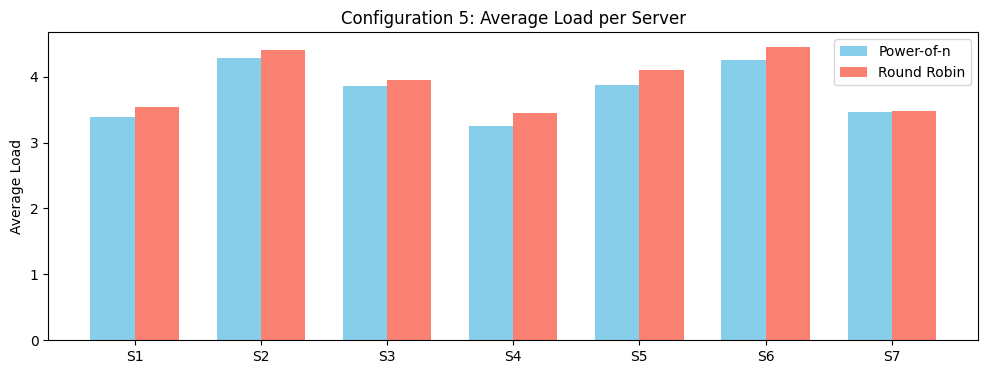


================ SERVER CONFIGURATION 1 ================

Server capacities: [5, 5, 5, 5, 5, 5, 5]
=== Power-of-n (average over 5 datasets) ===
Average load per server: [2.61 2.45 2.49 2.57 2.67 2.73 2.56]
Capacity utilization per server: [0.52 0.49 0.5  0.51 0.53 0.55 0.51]
Load variance over time: 2.0507
Peak load per server: [4.99 4.99 4.97 4.98 4.99 4.98 4.99]
Average queue length: 143.44
Task assignment efficiency: 0.8883
Total decision overhead: 6013.52

=== Round Robin (average over 5 datasets) ===
Average load per server: [2.98 2.96 2.93 2.82 2.85 2.82 2.91]
Capacity utilization per server: [0.6  0.59 0.59 0.56 0.57 0.56 0.58]
Load variance over time: 1.7926
Peak load per server: [4.99 4.99 4.98 4.99 4.99 4.98 4.98]
Average queue length: 124.76
Task assignment efficiency: 0.9359
Total decision overhead: 20548.92

================ SERVER CONFIGURATION 2 ================

Server capacities: [5, 6, 5, 7, 5, 6, 5]
=== Power-of-n (average over 5 datasets) ===
Average load per serve

In [ ]:
def print_metrics_per_config(avg_pn, avg_rr, config_idx, server_config):
    print(f"\n================ SERVER CONFIGURATION {config_idx+1} ================\n")
    print(f"Server capacities: {[c for c,_ in server_config]}")

    print("=== Power-of-n (average over 5 datasets) ===")
    print("Average load per server:", np.round(avg_pn[0], 2))
    print("Capacity utilization per server:", np.round(avg_pn[1], 2))
    print("Load variance over time:", round(avg_pn[2], 4))
    print("Peak load per server:", np.round(avg_pn[3], 2))
    print("Average queue length:", round(avg_pn[4], 2))
    print("Task assignment efficiency:", round(avg_pn[5], 4))
    print("Total decision overhead:", round(avg_pn[6], 2))

    print("\n=== Round Robin (average over 5 datasets) ===")
    print("Average load per server:", np.round(avg_rr[0], 2))
    print("Capacity utilization per server:", np.round(avg_rr[1], 2))
    print("Load variance over time:", round(avg_rr[2], 4))
    print("Peak load per server:", np.round(avg_rr[3], 2))
    print("Average queue length:", round(avg_rr[4], 2))
    print("Task assignment efficiency:", round(avg_rr[5], 4))
    print("Total decision overhead:", round(avg_rr[6], 2))


avg_pn_per_config = []
avg_rr_per_config = []

for idx, config_path in enumerate(server_config_paths):
    with open(config_path, "rb") as f:
        server_config = pickle.load(f)

    servers_len = len(server_config)

    def compute_average_metrics_corrected(metrics_list, server_config, total_tasks):

        avg_load=[]
        avg_util=[]
        avg_var=[]
        avg_peak=[]
        avg_queue=[]
        avg_eff=[]
        avg_overhead=[]

        for metric in metrics_list:
            usage,queue,assigned,overhead=metric
            capacities = [c for c,_ in server_config]
            avg_load.append([np.mean([u[i] for u in usage]) for i in range(len(capacities))])
            avg_util.append([np.mean([u[i]/capacities[i] for u in usage]) for i in range(len(capacities))])
            avg_var.append(np.mean([np.var(u) for u in usage]))
            avg_peak.append([max(u[i] for u in usage) for i in range(len(capacities))])
            avg_queue.append(np.mean(queue))
            avg_eff.append(assigned / total_tasks)
            avg_overhead.append(overhead)


        return (np.mean(avg_load,axis=0), np.mean(avg_util,axis=0),
                np.mean(avg_var), np.mean(avg_peak,axis=0),
                np.mean(avg_queue), np.mean(avg_eff), np.mean(avg_overhead))

    with open(datasets[0], "rb") as f:
        tasks_tmp, _ = pickle.load(f)
    total_tasks = len(tasks_tmp)

    avg_pn = compute_average_metrics_corrected(
        pn_results_per_config[idx], server_config, total_tasks
    )
    avg_rr = compute_average_metrics_corrected(
        rr_results_per_config[idx], server_config, total_tasks
    )

    avg_pn_per_config.append(avg_pn)
    avg_rr_per_config.append(avg_rr)

    x = np.arange(servers_len)
    width = 0.35
    plt.figure(figsize=(12,4))
    plt.bar(x - width/2, avg_pn[0], width, label='Power-of-n', color='skyblue')
    plt.bar(x + width/2, avg_rr[0], width, label='Round Robin', color='salmon')
    plt.xticks(x,[f"S{i+1}" for i in x])
    plt.ylabel("Average Load")
    plt.title(f"Configuration {idx+1}: Average Load per Server")
    plt.legend()
    plt.show()

for i in range(len(avg_pn_per_config)):
    with open(server_config_paths[i], "rb") as f:
        server_config = pickle.load(f)
    print_metrics_per_config(avg_pn_per_config[i], avg_rr_per_config[i], i, server_config)

In [ ]:
def print_metrics_per_dataset(avg_pn, avg_rr, dataset_idx):
    print(f"\n=== Dataset {dataset_idx+1} (prosjek preko svih konfiguracija) ===\n")

    print("=== Power-of-n ===")
    peak_percent_pn = np.round(avg_pn[2] * 100, 2)
    print("Capacity utilization per server:", np.round(avg_pn[0], 2))
    print("Load variance over time:", np.round(avg_pn[1], 4))
    print("Peak load per server (percentualno):", peak_percent_pn)
    print("Average queue length:", np.round(avg_pn[3], 2))
    print("Task assignment efficiency:", np.round(avg_pn[4], 4))
    print("Total decision overhead:", np.round(avg_pn[5], 2))

    print("\n=== Round Robin ===")
    peak_percent_rr = np.round(avg_rr[2] * 100, 2)
    print("Capacity utilization per server:", np.round(avg_rr[0], 2))
    print("Load variance over time:", np.round(avg_rr[1], 4))
    print("Peak load per server (percentualno):", peak_percent_rr)
    print("Average queue length:", np.round(avg_rr[3], 2))
    print("Task assignment efficiency:", np.round(avg_rr[4], 4))
    print("Total decision overhead:", np.round(avg_rr[5], 2))



def compute_average_metrics_per_dataset(metrics_list_per_config, server_configs_list, total_tasks):
    num_configs = len(metrics_list_per_config)
    num_servers = len(server_configs_list[0])

    avg_util_all = []
    avg_var_all = []
    avg_peak_all = []
    avg_queue_all = []
    avg_eff_all = []
    avg_overhead_all = []

    for cfg_idx in range(num_configs):
        usage, queue, assigned, overhead = metrics_list_per_config[cfg_idx]
        capacities = [c for c,_ in server_configs_list[cfg_idx]]

        avg_util = [np.mean([u[i]/capacities[i] for u in usage]) for i in range(num_servers)]
        avg_var = np.mean([np.var(u) for u in usage])
        avg_peak = [max(u[i] for u in usage)/capacities[i] for i in range(num_servers)]  
        avg_queue = np.mean(queue)
        avg_eff = assigned / total_tasks
        avg_overhead = overhead

        avg_util_all.append(avg_util)
        avg_var_all.append(avg_var)
        avg_peak_all.append(avg_peak)
        avg_queue_all.append(avg_queue)
        avg_eff_all.append(avg_eff)
        avg_overhead_all.append(avg_overhead)


    return (
        np.mean(avg_util_all, axis=0),
        np.mean(avg_var_all),
        np.mean(avg_peak_all, axis=0),
        np.mean(avg_queue_all),
        np.mean(avg_eff_all),
        np.mean(avg_overhead_all)
    )



server_configs_list = [pickle.load(open(p,"rb")) for p in server_config_paths]

for dataset_idx, dataset_path in enumerate(datasets):
    with open(dataset_path, "rb") as f:
        tasks, max_time = pickle.load(f)
    total_tasks = len(tasks)

    avg_pn_dataset = compute_average_metrics_per_dataset(
        [pn_results_per_config[i][dataset_idx] for i in range(len(server_config_paths))],
        server_configs_list,
        total_tasks
    )

    avg_rr_dataset = compute_average_metrics_per_dataset(
        [rr_results_per_config[i][dataset_idx] for i in range(len(server_config_paths))],
        server_configs_list,
        total_tasks
    )

    print_metrics_per_dataset(avg_pn_dataset, avg_rr_dataset, dataset_idx)



=== Dataset 1 (prosjek preko svih konfiguracija) ===

=== Power-of-n ===
Capacity utilization per server: [0.31 0.16 0.19 0.17 0.26 0.18 0.32]
Load variance over time: 2.3273
Peak load per server (percentualno): [99.73 93.44 98.65 93.85 96.87 97.06 99.16]
Average queue length: 0.01
Task assignment efficiency: 1.0
Total decision overhead: 221.08

=== Round Robin ===
Capacity utilization per server: [0.35 0.17 0.26 0.19 0.26 0.17 0.33]
Load variance over time: 2.2785
Peak load per server (percentualno): [99.41 92.54 98.9  89.04 98.32 87.74 99.05]
Average queue length: 0.01
Task assignment efficiency: 1.0
Total decision overhead: 179.0

=== Dataset 2 (prosjek preko svih konfiguracija) ===

=== Power-of-n ===
Capacity utilization per server: [0.54 0.37 0.45 0.38 0.49 0.37 0.51]
Load variance over time: 2.8679
Peak load per server (percentualno): [99.79 99.38 99.02 98.56 99.31 98.64 99.69]
Average queue length: 4.81
Task assignment efficiency: 0.9913
Total decision overhead: 2412.96

=== R